# Trackin validation

In [1]:
import os
import cv2
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from random import randint
from pycocotools.coco import COCO

NCAMS = 3

## Loads predicted results from csv file in a dataframe
- this is because in the csv file all images are included

In [2]:
# place for the images/data obtained from trackin app execution
trackin_path = "/mnt/PROJECTS/TrackIn/TrackinTest/Videos/20211203-1232/"

In [3]:
predicted_df = pd.read_csv(trackin_path + "data.csv", 
    names=["file", "str_data"],
    skiprows=1)
predicted_df.set_index('file', inplace=True)
print(predicted_df.head(10))

                                                                      str_data
file                                                                          
cam3_20210515-125500-304234                                                 []
cam2_20210515-125500-006130                                                 []
cam1_20210515-125500-558799                                                 []
cam2_20210515-125500-506682                                                 []
cam1_20210515-125501-068284                                                 []
cam3_20210515-125500-816719  [('0', '0', 1.0, -1, -1, -1, 1.0, True, {'rows...
cam1_20210515-125501-573216                                                 []
cam2_20210515-125501-010335                                                 []
cam3_20210515-125501-358932                                                 []
cam1_20210515-125502-180320                                                 []


In [4]:
predicted_df['raw_p_data'] = predicted_df.apply(lambda row: ast.literal_eval(row['str_data']), axis=1)

In [5]:
predicted_df.drop('str_data', axis=1, inplace=True)

In [6]:
a = predicted_df.loc[predicted_df['raw_p_data'].str.len()>0]

In [7]:
print(a.iloc[17]['raw_p_data'])

[('0', '0', 0.6807267060735097, 0.003982274752726763, 22, 'Female', 0.7874145563209256, True, {'rows': [0, 1], 'reid_prob': [[0.718006044626236], [0.596325010061264]], 'mean_reid_prob': [[0.7190120956565753], [0.6015059739078197]], 'iou_prob': [[0.18130567143078244], [0.021548989218449256]], 'p_prob': [[0.17562695672932596], [0.592296551896545]], 'pd_prob': [[0.9907328948615879], [0.9653862970604113]], 'FINAL': [[0.6807267060735097], [0.5691576040178353]], 'cols': [0]}, {'rows': [0, 1], 'reid_prob': [[0.5903866067528725], [0.6064003929495811]], 'mean_reid_prob': [[0.6037609142864313], [0.6096284631336151]], 'FINAL': [[0.6010860527797195], [0.6089828490968083]], 'trackid_prob': [[1], [0]], 'overlap_prob': [[1], [1]], 'cols': [0]}, [0.10209370542455602, 0.10153814156850179, 0.1443020944242124, 0.26894734700520834])]


In [8]:
a.iloc[17]['raw_p_data'][0][10]

[0.10209370542455602,
 0.10153814156850179,
 0.1443020944242124,
 0.26894734700520834]

In [9]:
def processed_data(data_list):
    data = []
    if len(data_list)>0:
        for d in data_list:
            dd = {
                'trid':d[0],
                'reid':d[1],
                'bbox':[d[10][0]*352,d[10][1]*198,d[10][2]*352,d[10][3]*198]
            }
            if d[7]==False:
                data.append(dd)
    return data

In [10]:
predicted_df['p_data'] = predicted_df.apply(lambda row: processed_data(row['raw_p_data']), axis=1)

In [11]:
predicted_df.drop('raw_p_data', axis=1, inplace=True)

## Load labelled data

In [12]:

label_folder = '/mnt/DATASSD/DataSandbox/TrackIn/'
dp_coco1 = COCO( label_folder + 'Canary/Labels_20210515_a/cam1.json')
dp_coco2 = COCO( label_folder + 'Canary/Labels_20210515_a/cam2.json')
dp_coco3 = COCO( label_folder + 'Canary/Labels_20210515_a/cam3.json')

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [13]:
# Get img id's for the minival dataset.
im_ids1 = dp_coco1.getImgIds()
im_ids2 = dp_coco2.getImgIds()
im_ids3 = dp_coco3.getImgIds()
# Select a random image id.
print("num ids ", len(im_ids1))
v = randint(0, len(im_ids1))
# v = 6195
print("rand ", v)
Selected_im1 = im_ids1[v]
print("selected ", Selected_im1)
im1 = dp_coco1.loadImgs(Selected_im1)[0]  
# Load Anns for the selected image.
ann_ids1 = dp_coco1.getAnnIds( imgIds=im1['id'] )
anns1 = dp_coco1.loadAnns(ann_ids1)
print("im ", im1, im1['id'])
print("anns ", anns1)
# Now read and b
im_name = os.path.join( label_folder + 'Canary/Images_20210515_a/Images',  im1['file_name'] )

num ids  6196
rand  1503
selected  1504
im  {'id': 1504, 'width': 352, 'height': 198, 'file_name': 'cam1_20210515-134013-712350.png', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0} 1504
anns  []


In [14]:
def get_labeled_df(im_idss, dp_cocos):
    labeled_data = {}
    for im_ids, dp_coco in zip(im_idss, dp_cocos):
        for i in range(len(im_ids)):
            anns_data = []
            imn = im_ids[i]
            ann_ids = dp_coco.getAnnIds( imgIds=imn )
            anns = dp_coco.loadAnns(ann_ids)
            im = dp_coco.loadImgs(imn)[0]
            label_im_name = im['file_name'][:-4]
            for ann in anns:
                l_bb = [ann['bbox'][0], ann['bbox'][1], ann['bbox'][0]+ann['bbox'][2], ann['bbox'][1]+ann['bbox'][3]]
                anns_data.append({'bbox':l_bb, 'trid':ann['attributes']['TrackID']})
            labeled_data[label_im_name] = {'l_data': anns_data}
    return labeled_data

labeled_data = get_labeled_df([im_ids1, im_ids2, im_ids3], [dp_coco1, dp_coco2, dp_coco3])

In [15]:
labeled_df = pd.DataFrame.from_dict(labeled_data, orient='index')
labeled_df.head(5)

,l_data
cam1_20210515-125500-558799,[]
cam1_20210515-125501-068284,[]
cam1_20210515-125501-573216,[]
cam1_20210515-125502-180320,[]
cam1_20210515-125502-674681,[]


In [27]:
print(labeled_df.loc['cam1_20210515-134206-998132'][0])

[{'bbox': [173.0, 57.2, 218.11, 119.71000000000001], 'trid': 'P001'}]


In [17]:
predicted_df.loc['cam1_20210515-134206-998132']

p_data    [{'trid': '0', 'reid': '186', 'bbox': [178.166...
Name: cam1_20210515-134206-998132, dtype: object

## Merge two dataframes

In [18]:
df = pd.merge(labeled_df, predicted_df, left_index=True, right_index=True)

In [19]:
df.reset_index(inplace=True)
df.head(10)

,index,l_data,p_data
0,cam1_20210515-125500-558799,[],[]
1,cam1_20210515-125501-068284,[],[]
2,cam1_20210515-125501-573216,[],[]
3,cam1_20210515-125502-180320,[],[]
4,cam1_20210515-125502-674681,[],[]
5,cam1_20210515-125503-256486,[],[]
6,cam1_20210515-125503-769836,[],[]
7,cam1_20210515-125504-259360,[],[]
8,cam1_20210515-125504-756984,[],[]
9,cam1_20210515-125505-354562,[],[]


In [20]:
df['cam'] = df.apply(lambda row: int(row['index'][3:4]), axis=1)

In [21]:
df.loc[df['index']=='cam1_20210515-134206-998132']

,index,l_data,p_data,cam
5174,cam1_20210515-134206-998132,"[{'bbox': [173.0, 57.2, 218.11, 119.7100000000...","[{'trid': '0', 'reid': '186', 'bbox': [178.166...",1


# visualize image and results

In [22]:
filename = 'cam2_20210515-125817-173162'
image_path = label_folder + 'Canary/Images_20210515_a/Images/' + filename + '.png'

In [23]:
selected_df = df.loc[df['index']==filename]
l_data = list(selected_df['l_data'])[0]
p_data = list(selected_df['p_data'])[0]

In [24]:
def draw_box(image, box, gt=True):
    image_h, image_w, _ = image.shape
    r_h, r_w = image_h/198,image_w/352

    xmin = int(box[0]*r_w)
    ymin = int(box[1]*r_h)
    xmax = int(box[2]*r_w)
    ymax = int(box[3]*r_h)

    if gt:
        color = (0,255,0)
    else:
        color = (0,0,255)

    cv2.rectangle(image, (xmin,ymin), (xmax,ymax), color, 2)
        
    return image

In [25]:
image = cv2.imread(image_path)
for i in range(len(l_data)):
    image = draw_box(image, l_data[i]['bbox'])
for i in range(len(p_data)):
    image = draw_box(image, p_data[i]['bbox'], False)

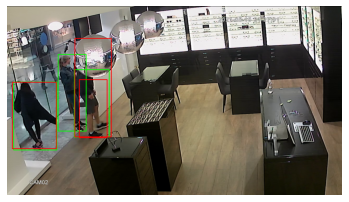

In [26]:
plt.imshow(image[:,:,::-1])
plt.axis('off')
plt.show()